### Signal Blackouts - Tracking a City Shuttle through GNSS Dropouts

1.  Generate a true trajectory for the shuttle.
2.  Simulate GNSS measurements with random dropouts.
3.  Implement a Kalman filter to track the shuttle's state (position and velocity) despite the signal gaps.
4.  Use the filter to make multi-step ahead predictions of the shuttle's path.
5.  Validate the filter's performance and compare its calculated errors against the true errors under various gap probabilities.

### 1. Setup and Trajectory Generation

First, we define the parameters for our simulation as specified in the assignment. We will then generate the true path of the shuttle and the corresponding noisy measurements, which include simulated signal dropouts.

In [43]:
import numpy as np
import matplotlib.pyplot as plt

N = 200         
T = 1.0         
x1 = 5.0        
v1 = 1.0        
sigma_a_sq = 0.2**2
sigma_n_sq = 20**2 

def generate_trajectory_and_measurements(N, T, x1, v1, sigma_a_sq, sigma_n_sq, P_gap):
    x_true = np.zeros(N)
    v_true = np.zeros(N)
    x_true[0] = x1
    v_true[0] = v1

    a = np.random.normal(0, np.sqrt(sigma_a_sq), N - 1)

    for i in range(1, N):
        x_true[i] = x_true[i - 1] + v_true[i - 1] * T + a[i - 1] * T**2 / 2
        v_true[i] = v_true[i - 1] + a[i - 1] * T

    n = np.random.normal(0, np.sqrt(sigma_n_sq), N)
    z = x_true + n

    xi = np.random.rand(N)
    z[xi <= P_gap] = np.nan 

    X_true = np.stack((x_true, v_true), axis=1)[:, :, np.newaxis]
    
    return X_true, z

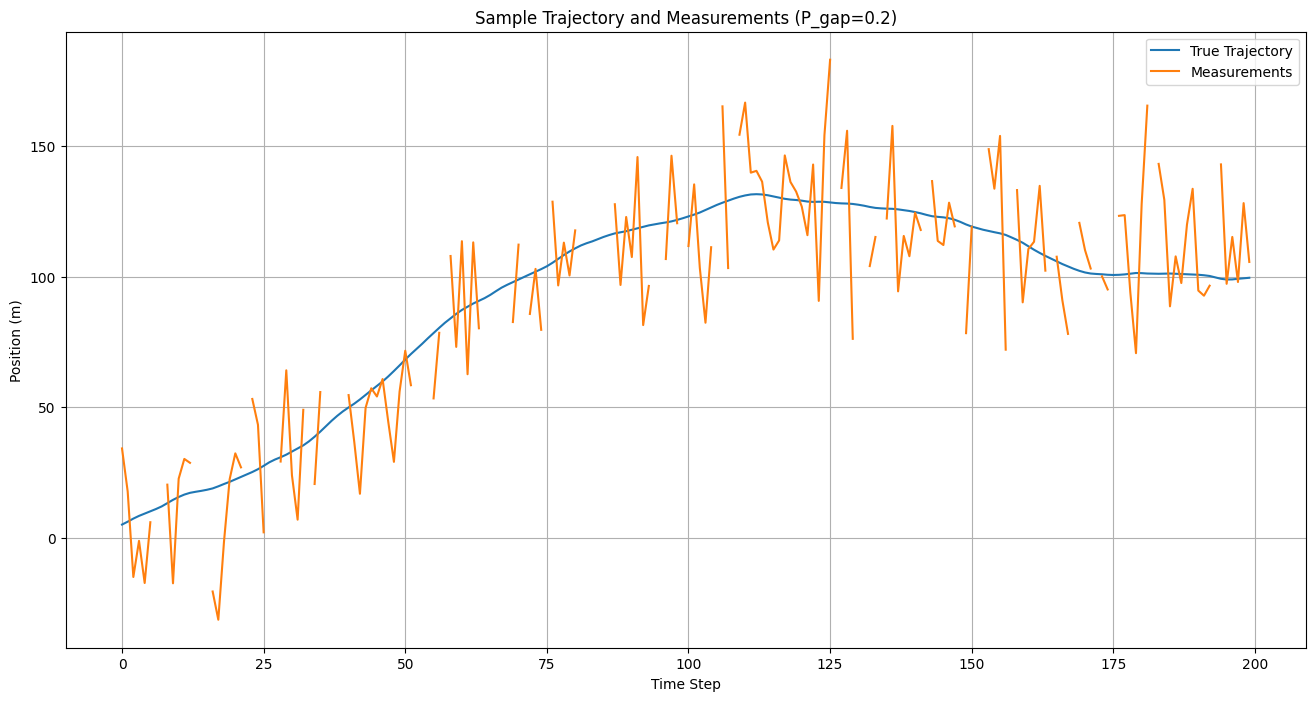

In [44]:
P_initial_gap = 0.2
X_true, z = generate_trajectory_and_measurements(N, T, x1, v1, sigma_a_sq, sigma_n_sq, P_initial_gap)

z_masked = np.ma.masked_invalid(z)

plt.figure(figsize=(16, 8))
plt.plot(X_true[:, 0], label='True Trajectory')
plt.plot(z_masked, markersize=3, label='Measurements')
plt.title('Sample Trajectory and Measurements (P_gap=0.2)')
plt.xlabel('Time Step')
plt.ylabel('Position (m)')
plt.legend()
plt.grid(True)
plt.show()

### 2. Kalman Filter Implementation

Here we define the Kalman filter. The provided base function is modified to handle the requirements of the assignment:
1.  **Gap Handling:** When a measurement `z[i]` is `NaN`, the filtration step is skipped. The filtered estimate is set equal to the predicted estimate (`X_i,i = X_i,i-1`), and the filtered covariance is set to the predicted covariance (`P_i,i = P_i,i-1`).
2.  **Multi-Step Prediction:** The function is adapted to calculate `m-1` steps ahead predictions at each time step `i`.

In [45]:
Phi = np.array([[1, T], [0, 1]])
G = np.array([[T**2 / 2], [T]])
H = np.array([[1, 0]])
Q = G @ G.T * sigma_a_sq
Ri = np.array([[sigma_n_sq]])

X0_0 = np.array([[x1], [v1]])
P0_0 = np.array([[1, 0], [0, 1]])
def run_kalman_filter(z, N, m_steps):
    X_filtered = np.zeros((N, 2, 1))
    P_filtered = np.zeros((N, 2, 2))
    X_predicted_1_step = np.zeros((N, 2, 1))
    P_predicted_1_step = np.zeros((N, 2, 2))
    X_predicted_m_step = np.zeros((N, 2, 1))
    P_predicted_m_step = np.zeros((N, 2, 2))
    
    X_filt_prev = X0_0
    P_filt_prev = P0_0

    for i in range(N):
        # prediction stage
        X_pred = Phi @ X_filt_prev
        P_pred = Phi @ P_filt_prev @ Phi.T + Q

        # filtration stage
        if np.isnan(z[i]):
            X_filt = X_pred
            P_filt = P_pred
        else:
            residual = z[i] - H @ X_pred
            S = H @ P_pred @ H.T + Ri
            K = P_pred @ H.T @ np.linalg.inv(S)
            X_filt = X_pred + K @ residual
            P_filt = (np.eye(2) - K @ H) @ P_pred

        X_m_step_temp = X_filt
        P_m_step_temp = P_filt
        for _ in range(m_steps - 1):
            X_m_step_temp = Phi @ X_m_step_temp
            P_m_step_temp = Phi @ P_m_step_temp @ Phi.T + Q
        
        X_predicted_1_step[i], P_predicted_1_step[i] = X_pred, P_pred
        X_filtered[i], P_filtered[i] = X_filt, P_filt
        X_predicted_m_step[i], P_predicted_m_step[i] = X_m_step_temp, P_m_step_temp
            
        X_filt_prev, P_filt_prev = X_filt, P_filt
        
    return X_filtered, P_filtered, X_predicted_1_step, P_predicted_1_step, X_predicted_m_step, P_predicted_m_step

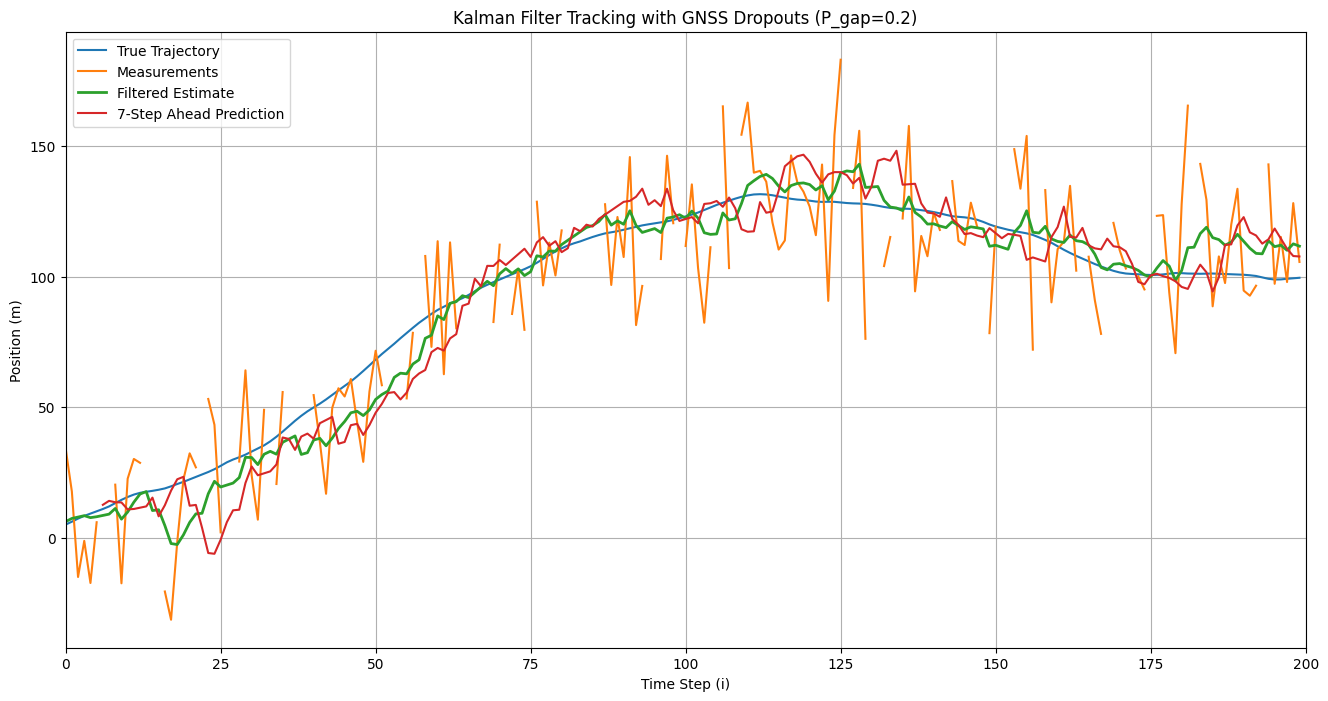

In [46]:
m = 7
X_f, P_f, X_p1, P_p1, X_pm, P_pm = run_kalman_filter(z, N, m)

plt.figure(figsize=(16, 8))
plt.plot(X_true[:, 0], label='True Trajectory')
plt.plot(z_masked, markersize=3, label='Measurements')
plt.plot(X_f[:, 0], linewidth=2, label='Filtered Estimate')

prediction_time_axis = np.arange(m - 1, N + m - 1)
plt.plot(prediction_time_axis[:N - (m-1)], X_pm[:N-(m-1), 0], label=f'{m}-Step Ahead Prediction')
plt.title(f'Kalman Filter Tracking with GNSS Dropouts (P_gap={P_initial_gap})')
plt.xlabel('Time Step (i)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid(True)
plt.xlim(0, N)
plt.show()

### 3. Error Estimation

To validate our filter, we compare its internally calculated error with the true error. We perform a 500 runs.

Analyzing three key error types:
1.  Filtered Error: The error in the final state estimate `X_i,i`.
2.  1-Step Prediction Error: The error in the state prediction `X_i+1,i`.
3.  7-Step Prediction Error: The error in the state prediction `X_i+m-1,i`.

In [47]:
def run_error_simulation(P_gap, M=500, m_steps=7):
    sq_err_filt = np.zeros((M, N))
    var_filt = np.zeros((M, N))
    
    sq_err_pred1 = np.zeros((M, N))
    var_pred1 = np.zeros((M, N))
    
    sq_err_pred_m = np.zeros((M, N))
    var_pred_m = np.zeros((M, N))

    for run in range(M):
        X_true, z = generate_trajectory_and_measurements(M, T, x1, v1, sigma_a_sq, sigma_n_sq, P_gap)
        Xf, Pf, Xp1, Pp1, Xpm, Ppm = run_kalman_filter(z[:N], N, m_steps)

        sq_err_filt[run, :] = (Xf[:, 0, 0] - X_true[:N, 0, 0])**2
        var_filt[run, :] = Pf[:, 0, 0]
        
        sq_err_pred1[run, :] = (Xp1[:, 0, 0] - X_true[:N, 0, 0])**2
        var_pred1[run, :] = Pp1[:, 0, 0]
        
        true_values_for_m_pred = np.array([X_true[i + m_steps - 1, 0, 0] for i in range(N)])
        sq_err_pred_m[run, :] = (Xpm[:, 0, 0] - true_values_for_m_pred)**2
        var_pred_m[run, :] = Ppm[:, 0, 0]

    rmse_filt, dev_filt = np.sqrt(np.mean(sq_err_filt, axis=0)), np.sqrt(np.mean(var_filt, axis=0))
    rmse_pred1, dev_pred1 = np.sqrt(np.mean(sq_err_pred1, axis=0)), np.sqrt(np.mean(var_pred1, axis=0))
    rmse_pred_m, dev_pred_m = np.sqrt(np.mean(sq_err_pred_m, axis=0)), np.sqrt(np.mean(var_pred_m, axis=0))
    
    return rmse_filt, dev_filt, rmse_pred1, dev_pred1, rmse_pred_m, dev_pred_m

gap_probabilities = [0.3, 0.5, 0.7, 0.9]
results = {}
for p in gap_probabilities:
    results[p] = run_error_simulation(p, M=500, m_steps=m)

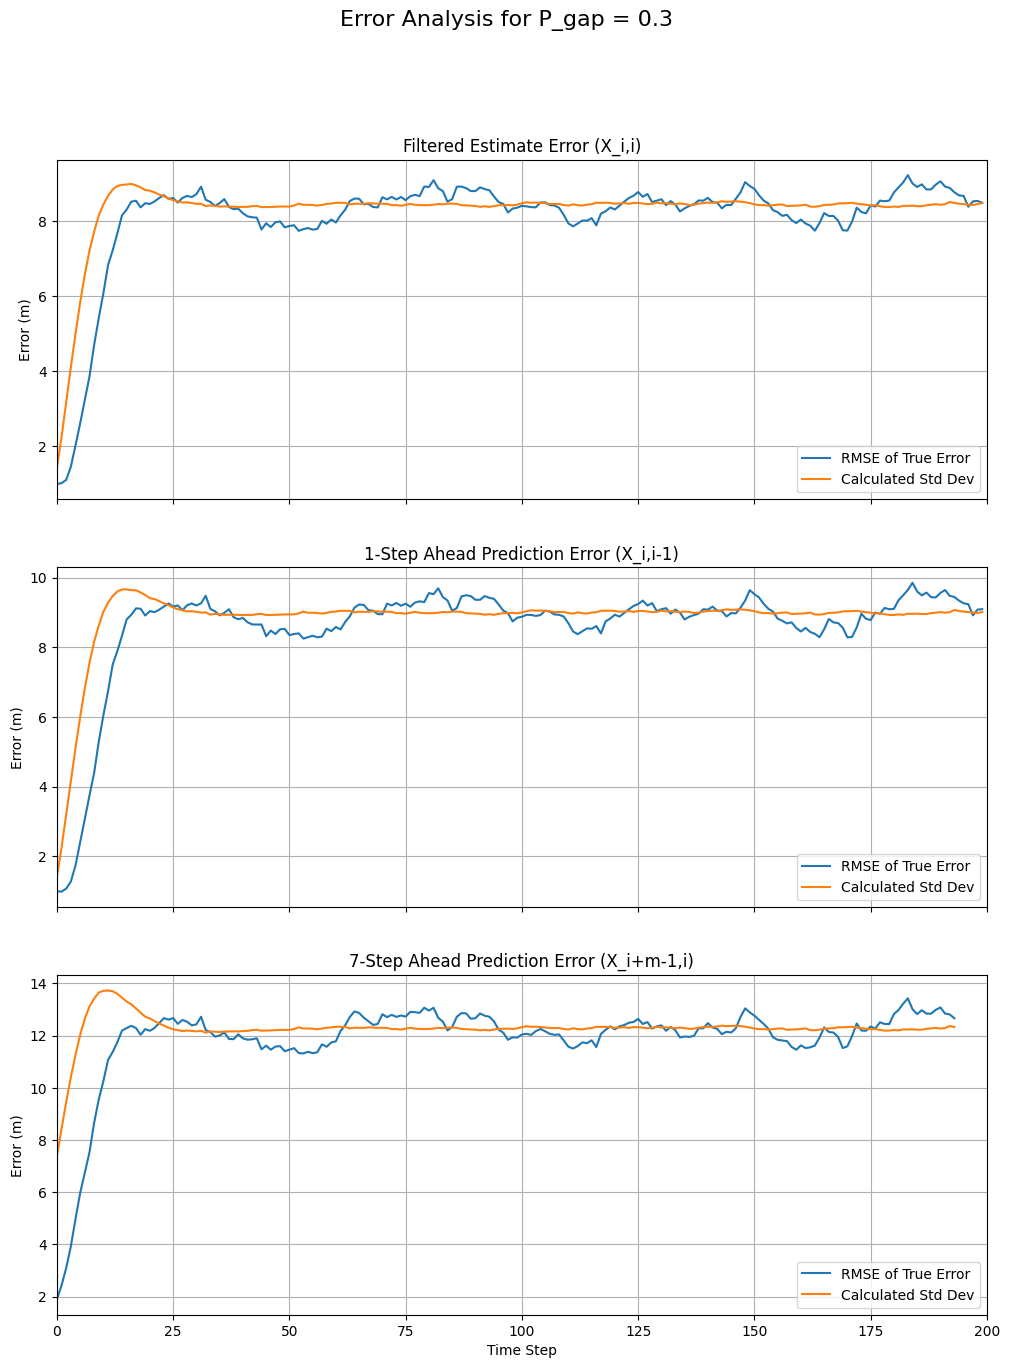

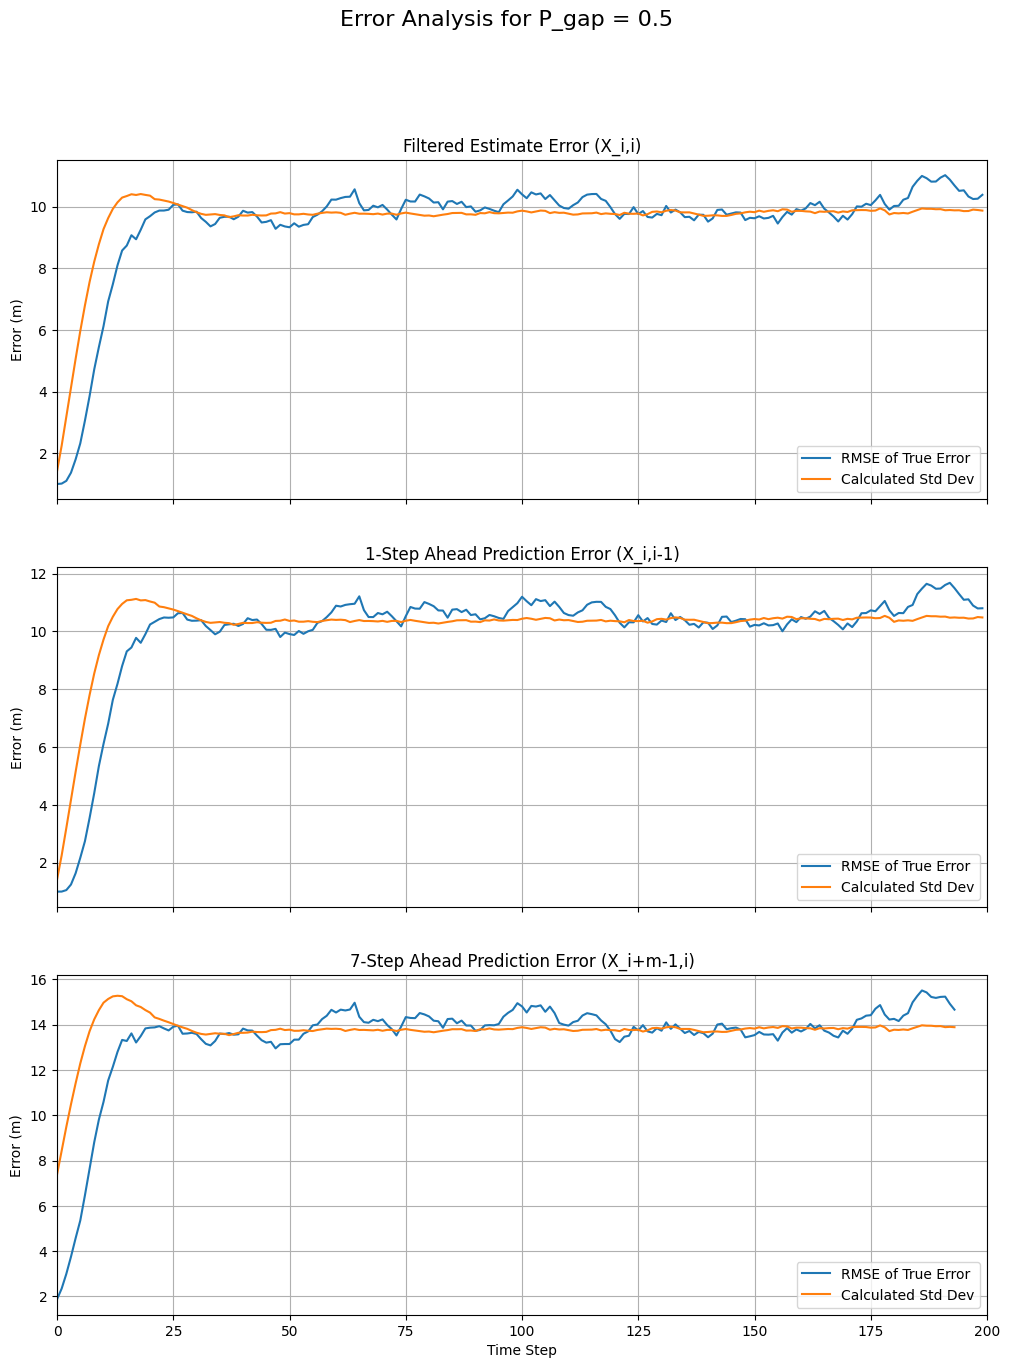

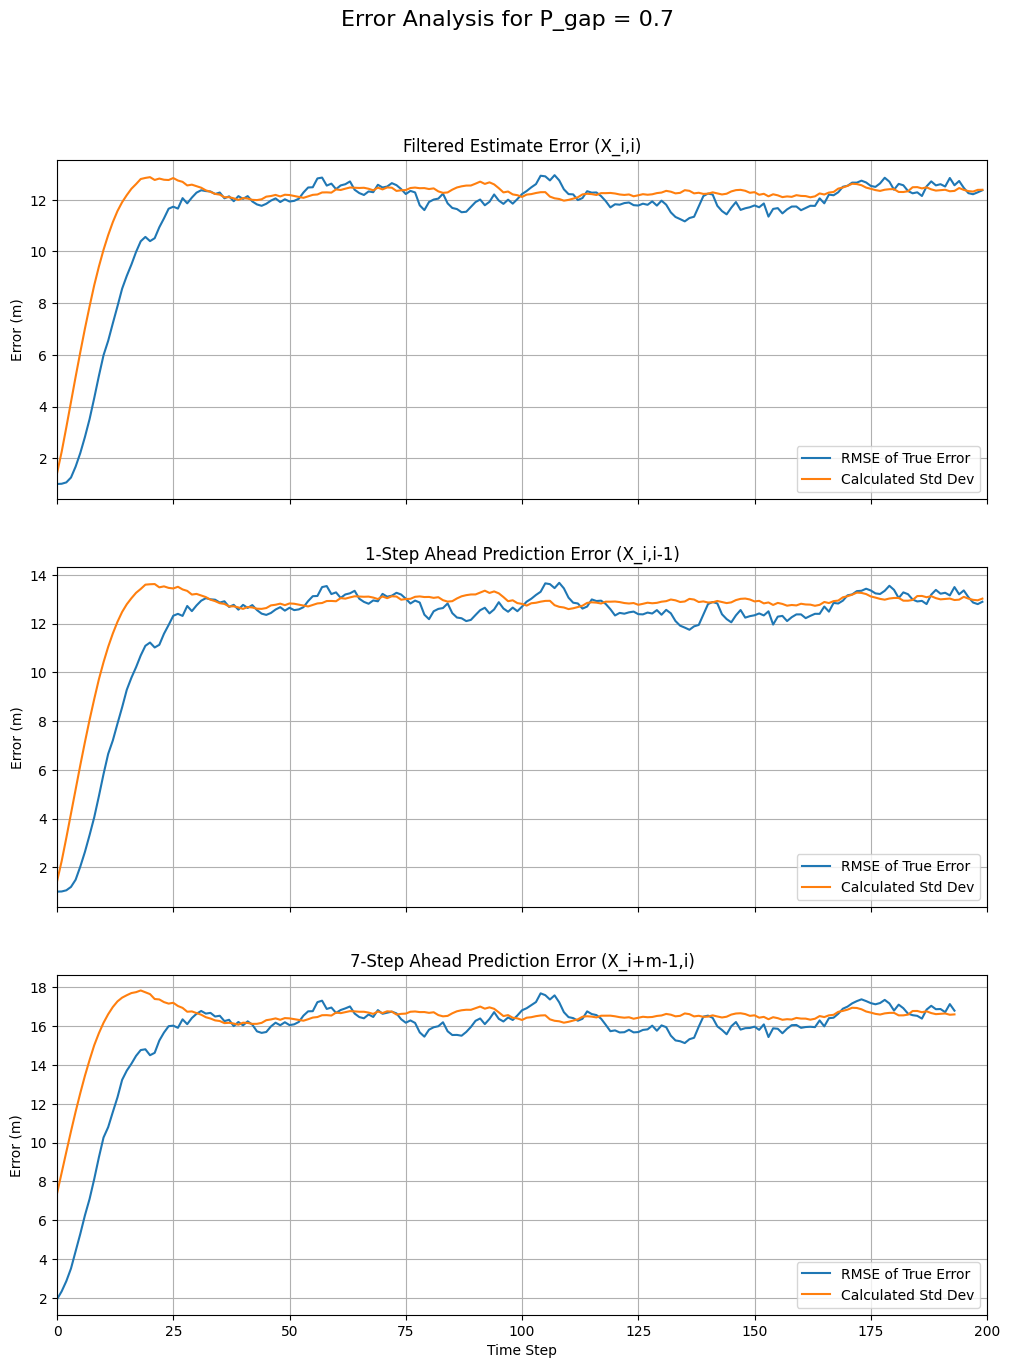

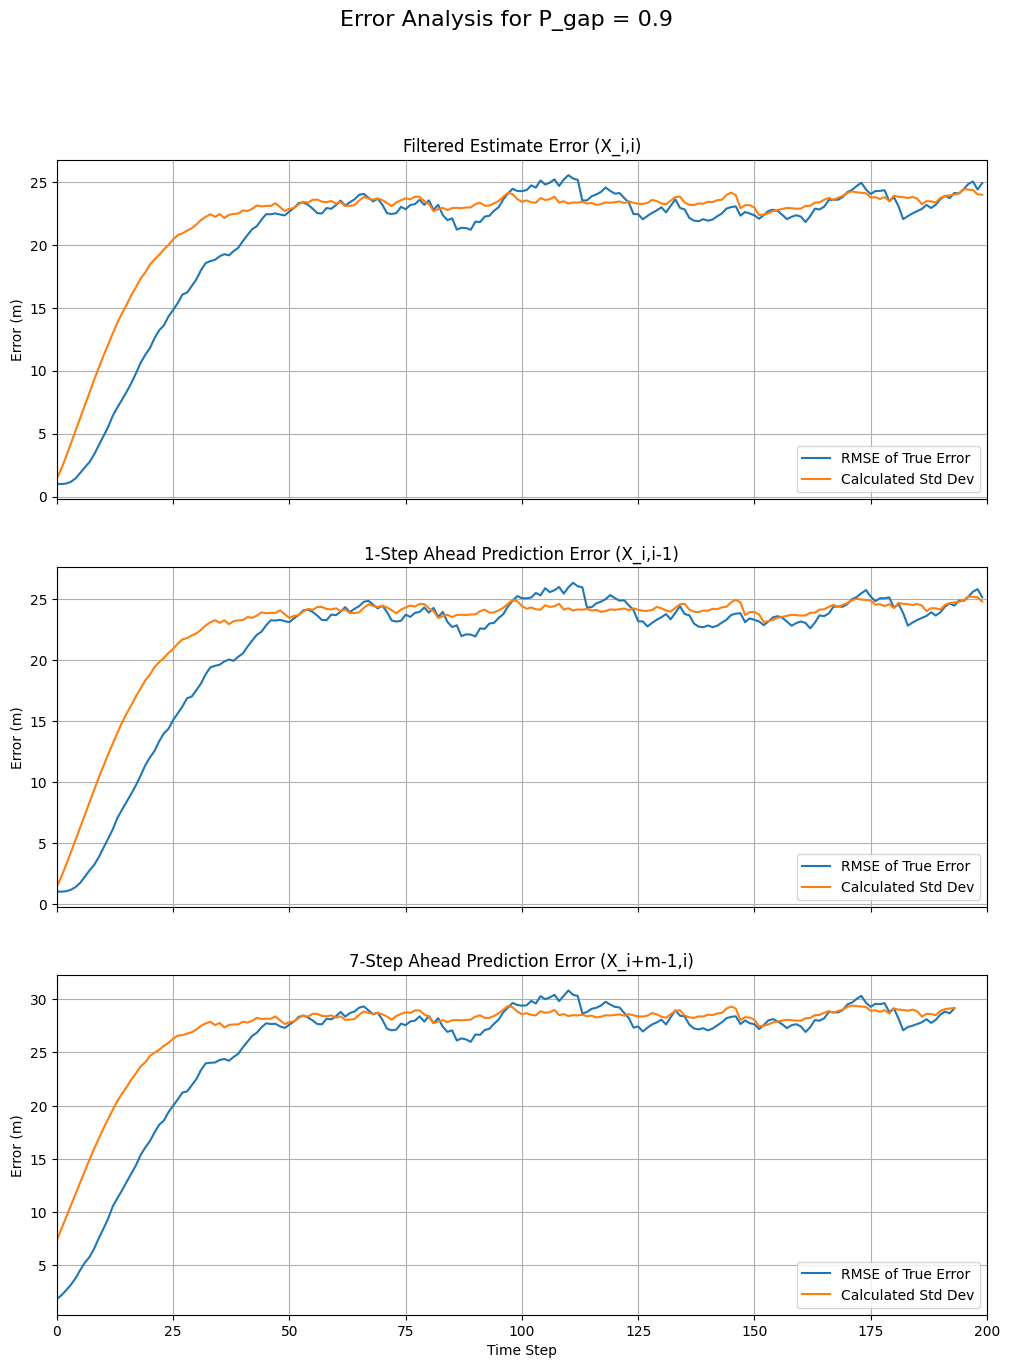

In [48]:
for p, data in results.items():
    rms_f, std_f, rms_p1, std_p1, rms_pm, std_pm = data
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    fig.suptitle(f'Error Analysis for P_gap = {p}', fontsize=16)

    axes[0].plot(rms_f, label='RMSE of True Error')
    axes[0].plot(std_f, label='Calculated Std Dev')
    axes[0].set_title('Filtered Estimate Error (X_i,i)')
    axes[0].set_ylabel('Error (m)')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(rms_p1, label='RMSE of True Error')
    axes[1].plot(std_p1, label='Calculated Std Dev')
    axes[1].set_title('1-Step Ahead Prediction Error (X_i,i-1)')
    axes[1].set_ylabel('Error (m)')
    axes[1].legend()
    axes[1].grid(True)

    plot_range = N - (m - 1)
    axes[2].plot(rms_pm[:plot_range], label='RMSE of True Error')
    axes[2].plot(std_pm[:plot_range], label='Calculated Std Dev')
    axes[2].set_title(f'{m}-Step Ahead Prediction Error (X_i+m-1,i)')
    axes[2].set_xlabel('Time Step')
    axes[2].set_ylabel('Error (m)')
    axes[2].legend()
    axes[2].grid(True)
    axes[2].set_xlim(0, N)

    plt.show()

### Learning Log

1. A key insight is how the filter behaves during a GNSS dropout. When a measurement is `NaN`, the filtration step is skipped. The filter's new estimation is based on its own prediction. Filter doesn't fail, it continues to track the object based on its internal model, while its uncertainty (represented by the covariance matrix `P`) naturally increases.

2. Errors estimation was crucial for building confidence in the filter's design. The close agreement between the RMSE and the calculated standard deviation is a profound result. It validates that the covariance matrix `P` is not just an intermediate variable but a meaningful, real-time measure of the filter's estimation uncertainty.

#### Impact of Measurement Gaps

The series of simulations with increasing gap probabilities (`P = 0.3, 0.5, 0.7`) clearly demonstrated the performance degradation:

- As `P` increases, the filter spends more time in "prediction-only" mode. This causes the error to grow significantly larger during these periods. The error plots for `P=0.7` show higher peaks in uncertainty compared to `P=0.3` and `P=0.5`.
- The accuracy of the m-step ahead predictions is highly dependent on the quality of the current filtered estimate. With more frequent gaps, the initial state for the prediction is more uncertain, leading to less reliable future forecasts. The error for the 7-step prediction grows to a higher level when `P` is large.